<a href="https://colab.research.google.com/github/UrmilaAirsang/Pytorch/blob/main/Pytorch_EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline for DNN
1. Prepare the data
2. Build the model
3. Train the model
4. Analyze the model

In [1]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

# Step1: Loading EMNIST by class data

In [7]:
# now let's work with FashionMnist

train_set = torchvision.datasets.EMNIST(
    split = 'byclass',
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

Extracting ./data/EMNIST/raw/emnist.zip to ./data/EMNIST/raw
Processing byclass
Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


#Step2 :Train Loader properties
1. shuffling the data 
2. setting the batch size

In [13]:
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=10
    ,shuffle=True
)
len(train_set)


697932

In [15]:
from pprint import pprint

pprint(max(train_set.train_labels)) # 0-61 is the label names


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor(61)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


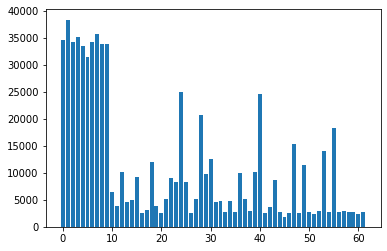

In [29]:
train_set.train_labels.bincount() #frequency of each label, we have unbalanced class here
# Bar graph for number of samples/class
import matplotlib.pyplot as plt  # This is python's popular plotting library.
# This is to ensure matplotlib plots inline and does not try to open a new window.
%matplotlib inline 
# Show the tensor.
def showTensor(aTensor):
    plt.figure()
    plt.bar(range(0,62),aTensor.numpy())
    plt.show()
    
showTensor(train_set.train_labels.bincount());

# visualizing the data

image shape: torch.Size([1, 28, 28])
label: 35


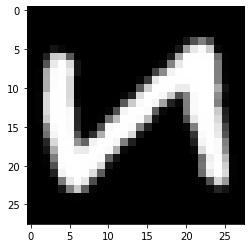

In [34]:
sample = next(iter(train_set))
image, label = sample
print("image shape:", image.shape)
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

#Step3: Network Building
1. 6 Convolution layers with these kernels (10, 10, 20, 20, 30)
2. no fully connected layer (use of Global Average Pooling layer)
3. use of EMNIST as the dataset - by_class 
4. use of one max-pooling layer

In [89]:
import torch.nn as nn
import torch.nn.functional as F
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=30, out_channels=62, kernel_size=3)

        #self.Adtap = nn.AdaptiveAvgPool2d(1)
        self.gap = nn.AvgPool2d(kernel_size=4)
        

        #self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        #self.fc2 = nn.Linear(in_features=120, out_features=60)
        #self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, inputTensor):
        # (1) input layer
        t = inputTensor    # input image size = 28*28*1

        # (2) hidden conv layer
        t = self.conv1(t)  # input size = 28*28*1  output = 26*26*10  RF = 3*3 
        t = F.relu(t)
        
        # (3) hidden conv layer
        t = self.conv2(t)  # input size = 26*26*10  output = 24*24*10  RF = 5*5 
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)  # input size = 24*24*10  output = 12*12*10  RF = 10*10 


        # (4) hidden conv layer
        t = self.conv3(t)  # input size = 12*12*10  output = 10*10*20  RF = 12*12 
        t = F.relu(t)

        # (5) hidden conv layer
        t = self.conv4(t)  # input size = 10*10*20  output = 8*8*20  RF = 14*14
        t = F.relu(t)
        #t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (6) hidden conv layer
        t = self.conv5(t)   # input size = 8*8*20  output = 6*6*30  RF = 16*16 
        t = F.relu(t)


        # (7) hidden conv layer
        t = self.conv6(t)  # input size = 6*6*30  output = 4*4*62  RF = 18*18
        

        # (8) output layer
       # t = self.Adtap(t)  # input size = 4*4*62  output = 1*1*62  RF = 28*28
        t = self.gap(t) #62 converted into 62 outputs
        t = F.softmax(t.view(-1,62), dim=1)

        return t

In [90]:
# from torchsummary import summary
# network = Network()
# summary(network,(1,28,28))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

#Step4: Network Training
1. network weights/paramters, image,labels are on cuda device
2. Calculated accuracy for every epoch

In [92]:
import torch.optim as optim
network = Network()
if torch.cuda.is_available():
    network.cuda()

device = torch.device('cuda:0')
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
optimizer = optim.SGD(network.parameters(), lr=0.01)

for epoch in range(25):
    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 
        images, labels = images.to(device),labels.to(device) 

        preds = network(images) # Pass Batch        
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss,
        "acc:",total_correct/len(train_set)
    )

epoch 0 total_correct: 23404 loss: 22504.437237739563 acc: 0.03353335281947238
epoch 1 total_correct: 24631 loss: 22501.673963069916 acc: 0.03529140374706991
epoch 2 total_correct: 28612 loss: 22492.879009723663 acc: 0.04099539783245359
epoch 3 total_correct: 74330 loss: 22091.18756365776 acc: 0.10650034673865076
epoch 4 total_correct: 152923 loss: 21464.921126127243 acc: 0.2191087383871208
epoch 5 total_correct: 166093 loss: 21357.218734264374 acc: 0.23797877157086936
epoch 6 total_correct: 172575 loss: 21306.159800052643 acc: 0.2472662093155207
epoch 7 total_correct: 199520 loss: 21098.12817287445 acc: 0.28587312230990986
epoch 8 total_correct: 202130 loss: 21074.611702680588 acc: 0.28961274164245226
epoch 9 total_correct: 203175 loss: 21065.29334807396 acc: 0.2911100221798112
epoch 10 total_correct: 203926 loss: 21059.07872390747 acc: 0.2921860582406309
epoch 11 total_correct: 204529 loss: 21054.0988574028 acc: 0.293050039258839
epoch 12 total_correct: 204985 loss: 21050.07965350151